In [1]:
import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

In [2]:
# ✅ STEP 1: Unzip Uploaded Dataset
import zipfile

with zipfile.ZipFile("fer2013.zip", 'r') as zip_ref:
    zip_ref.extractall("fer2013")

In [3]:
# ✅ STEP 2: Load and Preprocess Dataset

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from sklearn.utils import class_weight
import numpy as np

IMAGE_SIZE = (96, 96)
BATCH_SIZE = 64
train_path = "fer2013/train"
val_path = "fer2013/test"

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    zoom_range=0.1,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_data = train_datagen.flow_from_directory(
    train_path,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

val_data = val_datagen.flow_from_directory(
    val_path,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [4]:
# ✅ STEP 3: Compute Class Weights to Handle Imbalance

y_train = train_data.classes
class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(class_weights))

In [5]:
# ✅ STEP 4: Build Combined Model with MobileNetV2 + EfficientNetB0

from tensorflow.keras.applications import MobileNetV2, EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Input, Average
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

input_tensor = Input(shape=(96, 96, 3))

mobilenet = MobileNetV2(include_top=False, input_tensor=input_tensor, weights='imagenet')
mobilenet.trainable = False
x1 = GlobalAveragePooling2D()(mobilenet.output)
x1 = Dropout(0.3)(x1)
x1 = Dense(7, activation='softmax')(x1)

efficientnet = EfficientNetB0(include_top=False, input_tensor=input_tensor, weights='imagenet')
efficientnet.trainable = False
x2 = GlobalAveragePooling2D()(efficientnet.output)
x2 = Dropout(0.3)(x2)
x2 = Dense(7, activation='softmax')(x2)

avg_output = Average()([x1, x2])
ensemble_model = Model(inputs=input_tensor, outputs=avg_output)
ensemble_model.compile(optimizer=Adam(learning_rate=2e-4), loss='categorical_crossentropy', metrics=['accuracy'])

C:\Users\manop\AppData\Local\Temp\ipykernel_42292\2422404845.py:11: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  mobilenet = MobileNetV2(include_top=False, input_tensor=input_tensor, weights='imagenet')


In [6]:
# ✅ STEP 5: Training with Early Stopping

early_stop = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)

history = ensemble_model.fit(
    train_data,
    validation_data=val_data,
    epochs=20,
    class_weight=class_weights,
    callbacks=[early_stop],
    verbose=1
)

ensemble_model.save("ensemble_emotion_model.h5")

C:\Users\manop\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
449/449 ━━━━━━━━━━━━━━━━━━━━ 807s 2s/step - accuracy: 0.1743 - loss: 2.0402 - val_accuracy: 0.2487 - val_loss: 1.8901
Epoch 2/20
449/449 ━━━━━━━━━━━━━━━━━━━━ 231s 514ms/step - accuracy: 0.2713 - loss: 1.8548 - val_accuracy: 0.3306 - val_loss: 1.7517
Epoch 3/20
449/449 ━━━━━━━━━━━━━━━━━━━━ 226s 503ms/step - accuracy: 0.3083 - loss: 1.7816 - val_accuracy: 0.3303 - val_loss: 1.7554
Epoch 4/20
449/449 ━━━━━━━━━━━━━━━━━━━━ 228s 508ms/step - accuracy: 0.3026 - loss: 1.7813 - val_accuracy: 0.3447 - val_loss: 1.7218
Epoch 5/20
449/449 ━━━━━━━━━━━━━━━━━━━━ 228s 507ms/step - accuracy: 0.3220 - loss: 1.7579 - val_accuracy: 0.3518 - val_loss: 1.7117
Epoch 6/20
449/449 ━━━━━━━━━━━━━━━━━━━━ 227s 505ms/step - accuracy: 0.3389 - loss: 1.7222 - val_accuracy: 0.3774 - val_loss: 1.6693
Epoch 7/20
449/449 ━━━━━━━━━━━━━━━━━━━━ 231s 515ms/step - accuracy: 0.3455 - loss: 1.7224 - val_accuracy: 0.3491 - val_loss: 1.7118
Epoch 8/20
449/449 ━━━━━━━━━━━━━━━━━━━━ 234s 521ms/step - accuracy: 0.3374 - lo

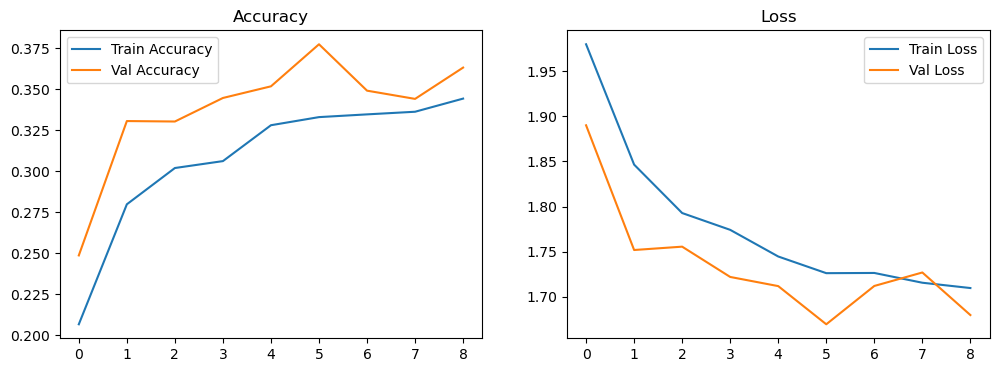

In [13]:
# ✅ STEP 6: Plot Training History

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Loss")
plt.legend()

plt.show()


In [224]:
import cv2
import numpy as np
from collections import Counter, deque

model = tf.keras.models.load_model("ensemble_emotion_model.h5")
emotion_labels = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
cap = cv2.VideoCapture(0)
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# 🎯 Track top predicted emotion history
emotion_history = deque(maxlen=30)

if not cap.isOpened():
    print("[ERROR] Cannot access webcam. Please check your camera.")
else:
    while True:
        ret, frame = cap.read()
        if not ret:
            break

        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        faces = face_cascade.detectMultiScale(gray, 1.3, 5)

        for (x, y, w, h) in faces:
            face = frame[y:y+h, x:x+w]
            face = cv2.resize(face, (96, 96))
            face = face.astype("float32") / 255.0
            face = np.expand_dims(face, axis=0)

            preds = model.predict(face, verbose=0)[0]
            top_idx = np.argsort(preds)[-3:][::-1]
            final_emotion = emotion_labels[top_idx[0]]

            # ⏺️ Add to history for final decision after camera closes
            emotion_history.append(final_emotion)

            # 👁️ Show top 3 on screen
            for i, idx in enumerate(top_idx):
                label = f"{emotion_labels[idx]} ({preds[idx]*100:.1f}%)"
                y_offset = y - 10 - i * 20
                cv2.putText(frame, label, (x, y_offset),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.7, (36, 255, 12), 2)

            cv2.rectangle(frame, (x, y), (x+w, y+h), (255, 0, 0), 2)

        cv2.imshow('Emotion Detection', frame)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()

    # ✅ Most frequent final emotion after webcam closes
    if emotion_history:
        final = Counter(emotion_history).most_common(1)[0][0]
        print(f"\n✅ Final Detected Emotion: {final.capitalize()}")
        get_recommendations_for_emotion(final)
    else:
        print("\n😕 No emotion detected.")



✅ Final Detected Emotion: Surprise

💡 Detected Emotion: Surprise

🎬 Movie Recommendations:
→ Justice League: Starcrossed - The Movie (2004)
→ Sherlock Jr. (1924)
→ Kizumonogatari Part 3: Reiketsu (2017)
→ Kizumonogatari Part 2: Nekketsu (2016)
→ Scooby-Doo! and Kiss: Rock and Roll Mystery (2015)

🎧 Playlist Recommendations:
🎵 Surprise dance songs 😽 → https://open.spotify.com/playlist/27DdSukpUSOEplhHsQHNrR
🎵 GABBY'S DOLLHOUSE - OFFICIAL PLAYLIST! → https://open.spotify.com/playlist/7KP4SLTutz6oQ1Fzkxfk7f


In [226]:
# ✅ STEP 8: Manual Mood Selection + Real Recommendations

available_moods = ['happy', 'sad', 'angry', 'fear', 'surprise', 'neutral', 'disgust']
print("\n--- Manual Mood Selection ---")
for i, mood in enumerate(available_moods):
    print(f"{i + 1}. {mood.capitalize()}")

try:
    choice = int(input("Select your mood (1-7): "))
    if 1 <= choice <= 7:
        selected_mood = available_moods[choice - 1]
        print(f"\n✅ You selected: {selected_mood.capitalize()}")

        print("\n🎬 Movie Recommendations:")
        for movie in get_movies_by_emotion(selected_mood):
            print("→", movie)

        print("\n🎧 Playlist Recommendations:")
        for playlist in get_playlists_by_emotion(selected_mood):
            print("🎵", playlist)
    else:
        print("❌ Invalid choice. Please enter a number between 1 and 7.")
except ValueError:
    print("❌ Please enter a valid number between 1 and 7.")



--- Manual Mood Selection ---
1. Happy
2. Sad
3. Angry
4. Fear
5. Surprise
6. Neutral
7. Disgust


Select your mood (1-7):  5



✅ You selected: Surprise

🎬 Movie Recommendations:
→ Justice League: Starcrossed - The Movie (2004)
→ Sherlock Jr. (1924)
→ Kizumonogatari Part 3: Reiketsu (2017)
→ Kizumonogatari Part 2: Nekketsu (2016)
→ Scooby-Doo! and Kiss: Rock and Roll Mystery (2015)

🎧 Playlist Recommendations:
🎵 90's COUNTRY HITS → https://open.spotify.com/playlist/2XfprUcSqwDFCti0sxmMq3
🎵 Surprise playlist → https://open.spotify.com/playlist/6KoNUd1VDZfFySnU741QTq
🎵 TAYLOR SWIFT - THE ERAS TOUR SETLIST + SURPRISE SONGS (US TOUR) → https://open.spotify.com/playlist/4EmsQV6bxL1tQ13bzZ2YoC
🎵 quince suprise dance  → https://open.spotify.com/playlist/4hERIH5N7XoTxdlB9t2vy7


In [91]:
import requests
import random

TMDB_API_KEY = "6e31f42d9623f1f0c42558cdc05b60a0"

def get_movies_by_emotion(emotion):
    genre_map = {
        'happy': 35,
        'sad': 18,
        'angry': 28,
        'fear': 27,
        'surprise': 9648,
        'disgust': 53,
        'neutral': 99
    }

    genre_id = genre_map.get(emotion.lower(), 18)  # fallback to Drama
    page = random.randint(1, 5)  # randomize page to get different movies
    
    url = (
        f"https://api.themoviedb.org/3/discover/movie"
        f"?api_key={TMDB_API_KEY}"
        f"&with_genres={genre_id}"
        f"&sort_by=vote_average.desc"
        f"&vote_count.gte=100"
        f"&page={page}"
    )

    response = requests.get(url)
    if response.status_code == 200:
        results = response.json().get('results', [])[:5]
        return [
            f"{movie['title']} ({movie['release_date'][:4]})"
            for movie in results if movie.get('release_date')
        ]
    else:
        return ["Could not fetch movies.", f"Status Code: {response.status_code}"]


In [100]:
print("🎬 Movie Suggestions for 'sad':")
for m in get_movies_by_emotion("sad"):
    print("→", m)


🎬 Movie Suggestions for 'sad':
→ Evangelion: 3.0+1.0 Thrice Upon a Time (2021)
→ Mommy (2014)
→ Il Sorpasso (1962)
→ Wolf Children (2012)
→ Saving Private Ryan (1998)


In [102]:
import requests
import base64

def get_spotify_token():
    client_id = "2b8479cdf4b142c38c0932fc4a8236ad"
    client_secret = "0b0ce7d8708a4bae9f73b610587ce83a"
    
    auth_str = f"{client_id}:{client_secret}"
    b64_auth = base64.b64encode(auth_str.encode()).decode()

    headers = {
        "Authorization": f"Basic {b64_auth}",
        "Content-Type": "application/x-www-form-urlencoded"
    }

    data = {"grant_type": "client_credentials"}

    response = requests.post("https://accounts.spotify.com/api/token", headers=headers, data=data)
    token = response.json().get("access_token")
    return token


In [122]:
import random

def get_playlists_by_emotion(emotion):
    token = get_spotify_token()
    headers = {
        "Authorization": f"Bearer {token}"
    }

    offset = random.randint(0, 50)  # shuffle results by skipping N items

    url = (
        f"https://api.spotify.com/v1/search"
        f"?q={emotion}&type=playlist&limit=5&offset={offset}"
    )

    response = requests.get(url, headers=headers)

    if response.status_code == 200:
        items = response.json().get("playlists", {}).get("items", [])
        
        results = []
        for item in items:
            if item is None:
                continue
            name = item.get('name')
            external = item.get('external_urls')
            url = external.get('spotify') if external else None
            if name and url:
                results.append(f"{name} → {url}")
        
        return results if results else ["No valid playlists found."]
    else:
        return [f"Could not fetch playlists. Status Code: {response.status_code}"]


In [150]:
print("🎧 Playlists for 'surprise':")
for p in get_playlists_by_emotion("fear"):
    print("🎵", p)


🎧 Playlists for 'surprise':
🎵 TEARS FOR FEARS - Greatest Hits → https://open.spotify.com/playlist/0GmOUDpkM8XcrhBZ1mjamV
🎵 Fear No Plague ♠️ → https://open.spotify.com/playlist/1iyXW8lVMRAeDF3BlJVoFN
🎵 Kai and Paedyn core → https://open.spotify.com/playlist/2taaGHd3SpYNZXZoccBY34
🎵 anti anxiety frequencies ✨ let go of worrying & overthinking 2025 → https://open.spotify.com/playlist/7d8hYSbp5vXOTrEtXVGEmj
🎵 The Only Thing They Fear Is You... → https://open.spotify.com/playlist/388nIvZ5PBUkvoSQKWAQj7


In [152]:
def get_recommendations_for_emotion(emotion):
    print(f"\n💡 Detected Emotion: {emotion.capitalize()}")
    
    # Movies
    print("\n🎬 Movie Recommendations:")
    movies = get_movies_by_emotion(emotion)
    for m in movies:
        print("→", m)

    # Music
    print("\n🎧 Playlist Recommendations:")
    playlists = get_playlists_by_emotion(emotion)
    for p in playlists:
        print("🎵", p)


In [154]:
label = emotion_labels[np.argmax(preds)]


In [166]:
get_recommendations_for_emotion(label)



💡 Detected Emotion: Fear (11.8%)

🎬 Movie Recommendations:
→ Fight Club (1999)
→ Cinema Paradiso (1988)
→ City of God (2002)
→ A Dog's Will (2000)
→ Impossible Things (2021)

🎧 Playlist Recommendations:
🎵 Fear → https://open.spotify.com/playlist/1p8LyQFVrGGlYZaN28qmPn
🎵 1% → https://open.spotify.com/playlist/3VcxgJLOpCE1jS0drqt1Cf
🎵 FEAR. → https://open.spotify.com/playlist/19vDLCHyCozqhMdCoAhy4S
🎵 1% → https://open.spotify.com/playlist/0voL3idiZ1Er8EnMP6SZaE
🎵 8% → https://open.spotify.com/playlist/593FvAaA8gGJX8RRkIukfj


In [174]:
preds = model.predict(face, verbose=0)[0]
top_idx = np.argsort(preds)[-3:][::-1]  # get top 3

# Print all top 3
for i in top_idx:
    print(f"{emotion_labels[i]} → {preds[i]*100:.2f}%")

# Choose the highest confidence one
final_emotion = emotion_labels[top_idx[0]]
print(f"\n✅ Final Emotion Output: {final_emotion}")

# Use it for recommendations
get_recommendations_for_emotion(final_emotion)


surprise → 51.54%
fear → 11.79%
angry → 11.61%

✅ Final Emotion Output: surprise

💡 Detected Emotion: Surprise

🎬 Movie Recommendations:
→ Justice League: Starcrossed - The Movie (2004)
→ Sherlock Jr. (1924)
→ Kizumonogatari Part 3: Reiketsu (2017)
→ Kizumonogatari Part 2: Nekketsu (2016)
→ Scooby-Doo! and Kiss: Rock and Roll Mystery (2015)

🎧 Playlist Recommendations:
🎵 Surprise → https://open.spotify.com/playlist/21NbEbUUUSDJw4hqUZC03U
🎵 Taylor Swift Complete Eras Tour + all Surprise  Songs → https://open.spotify.com/playlist/03BdIUJX3qTaHmBriFMPM6
🎵 🧫Surprise🥵 → https://open.spotify.com/playlist/0d7IYiYfoKWCyvHj6WH3E0
🎵 LIT QUINCE DANCE PLAYLIST 😎🎉 → https://open.spotify.com/playlist/70STWYSNHki7Z9A3QmAIlM
🎵 Rainbow Kitten Surprise Discography → https://open.spotify.com/playlist/0FwT8WLYLzqaqi3swp0SqU


In [200]:
# WEBSITE BUILDING

import streamlit as st
import numpy as np
import cv2
import tempfile
from PIL import Image
import tensorflow as tf
import requests
import base64
import random

# Load model
model = tf.keras.models.load_model("ensemble_emotion_model.h5")
IMAGE_SIZE = (96, 96)
emotion_labels = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

# TMDb Movie Recommender
TMDB_API_KEY = "6e31f42d9623f1f0c42558cdc05b60a0"
def get_movies_by_emotion(emotion):
    genre_map = {
        'happy': 35, 'sad': 18, 'angry': 28, 'fear': 27,
        'surprise': 9648, 'disgust': 53, 'neutral': 99
    }
    genre_id = genre_map.get(emotion.lower(), 18)
    page = random.randint(1, 5)
    url = f"https://api.themoviedb.org/3/discover/movie?api_key={TMDB_API_KEY}&with_genres={genre_id}&sort_by=vote_average.desc&vote_count.gte=100&page={page}"
    response = requests.get(url)
    if response.status_code == 200:
        results = response.json().get('results', [])[:5]
        return [f"{m['title']} ({m['release_date'][:4]})" for m in results if m.get('release_date')]
    return ["Error fetching movies"]

# Spotify Music Recommender
SPOTIFY_CLIENT_ID = "2b8479cdf4b142c38c0932fc4a8236ad"
SPOTIFY_CLIENT_SECRET = "0b0ce7d8708a4bae9f73b610587ce83a"
def get_spotify_token():
    auth_str = f"{SPOTIFY_CLIENT_ID}:{SPOTIFY_CLIENT_SECRET}"
    b64_auth = base64.b64encode(auth_str.encode()).decode()
    headers = {"Authorization": f"Basic {b64_auth}", "Content-Type": "application/x-www-form-urlencoded"}
    data = {"grant_type": "client_credentials"}
    response = requests.post("https://accounts.spotify.com/api/token", headers=headers, data=data)
    return response.json().get("access_token")

def get_playlists_by_emotion(emotion):
    token = get_spotify_token()
    headers = {"Authorization": f"Bearer {token}"}
    offset = random.randint(0, 50)
    url = f"https://api.spotify.com/v1/search?q={emotion}&type=playlist&limit=5&offset={offset}"
    response = requests.get(url, headers=headers)
    if response.status_code == 200:
        items = response.json().get("playlists", {}).get("items", [])
        results = []
        for item in items:
            if item and item.get('external_urls'):
                name = item.get('name')
                link = item['external_urls'].get('spotify')
                if name and link:
                    results.append(f"{name} → {link}")
        return results
    return ["Error fetching playlists"]

# Predict Emotion
def predict_emotion(image):
    image = cv2.resize(image, IMAGE_SIZE)
    image = image.astype("float32") / 255.0
    image = np.expand_dims(image, axis=0)
    preds = model.predict(image)[0]
    top_idx = np.argsort(preds)[-3:][::-1]
    result = [(emotion_labels[i], float(preds[i])) for i in top_idx]
    return result

# Streamlit UI
st.set_page_config(page_title="Emotion-Based Recommender", layout="centered")
st.title("🧠 Real-Time Emotion Analysis & Recommendations")

option = st.radio("Choose input mode:", ["📸 Upload Image", "🧍 Manual Mood", "🎥 Webcam (Capture Frame)"])

if option == "📸 Upload Image":
    uploaded_file = st.file_uploader("Upload a facial image", type=["jpg", "png", "jpeg"])
    if uploaded_file:
        image = Image.open(uploaded_file).convert('RGB')
        img_np = np.array(image)
        st.image(img_np, caption="Uploaded Image", use_column_width=True)

        top3 = predict_emotion(img_np)
        final_emotion = top3[0][0]

        st.subheader("🔍 Detected Emotions:")
        for emo, score in top3:
            st.write(f"{emo.capitalize()} — {score*100:.2f}%")

        st.success(f"Detected Dominant Emotion: **{final_emotion.capitalize()}**")

        st.markdown("---")
        st.subheader("🎬 Movie Recommendations:")
        for m in get_movies_by_emotion(final_emotion):
            st.write("→", m)

        st.subheader("🎧 Music Playlists:")
        for p in get_playlists_by_emotion(final_emotion):
            st.write("🎵", p)

elif option == "🧍 Manual Mood":
    selected_mood = st.selectbox("Choose your current mood:", emotion_labels)
    st.success(f"You selected: {selected_mood.capitalize()}")

    st.subheader("🎬 Movie Recommendations:")
    for m in get_movies_by_emotion(selected_mood):
        st.write("→", m)

    st.subheader("🎧 Music Playlists:")
    for p in get_playlists_by_emotion(selected_mood):
        st.write("🎵", p)

elif option == "🎥 Webcam (Capture Frame)":
    st.warning("📷 Webcam access is not supported directly in hosted Streamlit. Run locally to use this.")
    st.code("Use OpenCV-based webcam detection in your local environment to get emotion output and feed it here manually.")

2025-04-22 11:14:21.735 
  command:

    streamlit run C:\Users\manop\anaconda3\Lib\site-packages\ipykernel_launcher.py [ARGUMENTS]
2025-04-22 11:14:21.735 Session state does not function when running a script without `streamlit run`
